In [89]:
using Pkg
Pkg.activate("..")  #one level up, where Project.toml lives
Pkg.instantiate()   #download/install anything missing
# Pkg.status();

  Activating project at `~/Documents/repos/JuliaExploreHRM`


In [91]:
# --- Data generator (load once) ---------------------------------------------
if !isdefined(Main, :BooleanDataGenerator)
    include(joinpath(@__DIR__, "..", "data", "nested_boolean_gen.jl"))
end
using .BooleanDataGenerator

# --- Paths -------------------------------------------------------------------
const HRM_CPU_FILE = joinpath(@__DIR__, "..", "data", "hrm_common_nested_boolean_FLUX.jl")
const HRM_GPU_FILE = joinpath(@__DIR__, "..", "data", "hrm_common_nested_boolean_FLUX_GPU.jl")

# --- Crude GPU check ---------------------------------------------------------
use_gpu = false
gpu_reason = ""
try
    import CUDA
    use_gpu = isfile(HRM_GPU_FILE) && CUDA.has_cuda_gpu() && CUDA.functional()
    gpu_reason = use_gpu ? "CUDA: $(CUDA.name(CUDA.device()))" : "No functional CUDA GPU / missing GPU file"
catch err
    gpu_reason = "CUDA check failed: $(err)"
end

# --- Force-load chosen HRMFlux INTO Main (replaces existing module if any) ---
if use_gpu
    Base.include(Main, HRM_GPU_FILE)   # defines/replaces `module HRMFlux ... end` in Main
    chosen      = "GPU"
    chosen_path = HRM_GPU_FILE
else
    Base.include(Main, HRM_CPU_FILE)
    chosen      = "CPU"
    chosen_path = HRM_CPU_FILE
end

# Bring HRMFlux into scope (no rename, no alias)
using .HRMFlux

println("HRMFlux loaded: $chosen  | file: $chosen_path  | $gpu_reason")

# --- H+H baseline (load once; same pattern) ---------------------------------
if !isdefined(Main, :HRMFluxHH)
    Base.include(Main, joinpath(@__DIR__, "..", "data", "hh_nested_boolean_FLUX.jl"))
end
using .HRMFluxHH

# --- Common deps -------------------------------------------------------------
using StatsBase
using Random, Statistics
using Flux, Zygote, Optimisers
using Flux: onehotbatch, onecold
using DataFrames, Plots, CSV
using Functors


HRMFlux loaded: GPU  | file: /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/../data/hrm_common_nested_boolean_FLUX_GPU.jl  | CUDA: Quadro T2000


In [93]:
using CUDA, Functors
# using Flux: gpu          # (alternative)

models = HRMFlux.build_models(cfg)

if CUDA.has_cuda_gpu() && CUDA.functional()
    models = Functors.fmap(CUDA.cu, models)   # <- use CUDA.cu explicitly
    # models = Functors.fmap(gpu, models)     # <- works too, IF you `using Flux: gpu`
    CUDA.allowscalar(false)
end

xb     = Xids_tr_A[:, 1:4]
xb_dev = CUDA.cu(xb)

@info ("types", typeof(models.tok_emb.weight), typeof(xb_dev), eltype(xb_dev))
E = models.tok_emb(xb_dev)
@info ("embedding OK", typeof(E))



┌ Info: ("types", CuArray{Float32, 2, CUDA.DeviceMemory}, CuArray{Int64, 2, CUDA.DeviceMemory}, Int64)
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y104sZmlsZQ==.jl:15
┌ Info: ("embedding OK", CuArray{Float32, 3, CUDA.DeviceMemory})
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y104sZmlsZQ==.jl:17


In [94]:
Base.@kwdef mutable struct TrainLog{T<:AbstractFloat}
    model::String
    epochs::Vector{Int}      = Int[]
    pB::Vector{T}            = T[]
    loss::Vector{T}          = T[]
    id::Vector{T}            = T[]
    mid::Vector{T}           = T[]
    ood::Vector{T}           = T[]
    ood7::Vector{T}          = T[]
    ood8::Vector{T}          = T[]
end

newlog(model::String; T::Type{<:AbstractFloat}=Float32) = TrainLog{T}(model=model)


function push_epoch!(log::TrainLog{T};
    epoch::Integer,
    pB::Real, loss::Real,
    acc_id::Real, acc_mid::Real, acc_ood::Real,
    acc7::Real, acc8::Real
) where {T}
    push!(log.epochs, Int(epoch))
    push!(log.pB,   T(pB))
    push!(log.loss, T(loss))
    push!(log.id,   T(acc_id))
    push!(log.mid,  T(acc_mid))
    push!(log.ood,  T(acc_ood))
    push!(log.ood7, T(acc7))
    push!(log.ood8, T(acc8))
    return log
end
# Training data (depth 2-4)
X_train, y_trainainainain, _ = BooleanDataGenerator.generate_data(100; min_depth=2, max_depth=4)

# Test data (depth 5-8) 
X_test, y_test, _ = BooleanDataGenerator.generate_data(20; min_depth=5, max_depth=8)

# Test data (held-out NAND)
X_test_ops, y_test_ops, _ = BooleanDataGenerator.generate_data(20; held_out_ops=[:NAND])

function to_dataframe(log::TrainLog{T}) where {T}
    n = length(log.epochs)
    return DataFrame(
        model = fill(log.model, n),
        epoch = log.epochs,
        pB    = log.pB,
        loss  = log.loss,
        ID    = log.id,
        MID   = log.mid,
        OOD   = log.ood,
        OOD7  = log.ood7,
        OOD8  = log.ood8,
    )
end


function summarize(log::TrainLog)
    n = length(log.epochs)
    if n == 0
        return (model=log.model, last=nothing, peak_ood=nothing)
    end
    i_last = n
    i_peak_ood = argmax(log.ood)
    return (
        model = log.model,
        last = (
            epoch = log.epochs[i_last],
            pB    = log.pB[i_last],
            loss  = log.loss[i_last],
            ID    = log.id[i_last],
            MID   = log.mid[i_last],
            OOD   = log.ood[i_last],
            OOD7  = log.ood7[i_last],
            OOD8  = log.ood8[i_last],
        ),
        peak_ood = (
            epoch = log.epochs[i_peak_ood],
            pB    = log.pB[i_peak_ood],
            ID    = log.id[i_peak_ood],
            MID   = log.mid[i_peak_ood],
            OOD   = log.ood[i_peak_ood],
        )
    )
end



summarize (generic function with 1 method)

In [95]:
N_TRAIN = 100
N_TEST  = 20

# ID (train): depths 2–4
X_train, y_train, meta_train =
    BooleanDataGenerator.generate_data(N_TRAIN; min_depth=2, max_depth=4)

# MID (test): depth 5
X_test_mid, y_test_mid, meta_mid =
    BooleanDataGenerator.generate_data(N_TEST; min_depth=5, max_depth=5)

# OOD (test): depths 6–8 (aggregate)
X_test_ood, y_test_ood, meta_ood =
    BooleanDataGenerator.generate_data(N_TEST; min_depth=6, max_depth=8)

# OOD by specific depths to match your log columns (OOD7, OOD8)
X_test_ood7, y_test_ood7, _ =
    BooleanDataGenerator.generate_data(N_TEST; min_depth=7, max_depth=7)

X_test_ood8, y_test_ood8, _ =
    BooleanDataGenerator.generate_data(N_TEST; min_depth=8, max_depth=8)

# Held-out operator variant (example: NAND)
X_test_ops, y_test_ops, meta_ops =
    BooleanDataGenerator.generate_data(N_TEST; held_out_ops=[:NAND])


([0 1 … 1 0; 1 1 … 0 1; … ; 1 1 … 0 1; 1 0 … 1 0], [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0], ["(OR x4 x5)", "(NOT x1)", "(XOR x1 (AND x1 x2))", "(AND (XOR x4 (XOR x2 x3)) x3)", "(XOR x3 x5)", "(NOT x1)", "(XOR x1 x1)", "(NOT (AND x5 x1))", "(OR x1 (XOR x5 x2))", "(NOT x2)", "(NOT (OR x1 (AND x1 x3)))", "(NOT (XOR (OR x1 x5) x4))", "(AND x2 (AND x4 x3))", "(AND x1 x2)", "(OR (OR x5 x1) x1)", "(NOT x4)", "(OR x2 x2)", "(AND (XOR x2 x4) x2)", "(AND x4 x4)", "(AND x2 x5)"])

In [96]:
# --- keep your original code exactly as-is -----------------------------------
# Generate training data (depth 2-4)
X_train, y_train, expr_train =
    BooleanDataGenerator.generate_data(100; min_depth=2, max_depth=4, seed=42)

# Generate test data with depth generalization (depth 5-8, aggregated)
X_test, y_test, expr_test =
    BooleanDataGenerator.generate_data(20; min_depth=5, max_depth=8, seed=123)

# Generate test data with held-out operations (no NAND)
X_test_ops, y_test_ops, expr_test_ops =
    BooleanDataGenerator.generate_data(20; held_out_ops=[:NAND], seed=456)

println("Training:    X=$(size(X_train)), y=$(size(y_train))")
println("Test (depth): X=$(size(X_test)),  y=$(size(y_test))")
println("Test (ops):   X=$(size(X_test_ops)), y=$(size(y_test_ops))")

println("\nTraining examples:")
for i in 1:min(3, size(X_train, 1))   # guard in case dataset size changes
    println("$(expr_train[i]) | vars=$(X_train[i,:]) → $(y_train[i])")
end

# --- OPTIONAL (only if you want MID/OOD7/OOD8 metrics without renaming) ------
# These *add* variables; they don't change the originals above.
# Use distinct seeds so the subsets aren't identical by chance.
X_test_mid,  y_test_mid,  expr_test_mid  =
    BooleanDataGenerator.generate_data(20; min_depth=5, max_depth=5, seed=223)

X_test_ood7, y_test_ood7, expr_test_ood7 =
    BooleanDataGenerator.generate_data(20; min_depth=7, max_depth=7, seed=224)

X_test_ood8, y_test_ood8, expr_test_ood8 =
    BooleanDataGenerator.generate_data(20; min_depth=8, max_depth=8, seed=225)



Training:    X=(100, 5), y=(100,)
Test (depth): X=(20, 5),  y=(20,)
Test (ops):   X=(20, 5), y=(20,)

Training examples:
(OR x4 x5) | vars=[0, 1, 1, 1, 0] → 1
(NOT x1) | vars=[1, 1, 1, 0, 1] → 0
(NAND x1 (AND x1 x2)) | vars=[0, 1, 1, 0, 1] → 1


([1 1 … 0 0; 1 0 … 1 0; … ; 1 1 … 0 1; 1 0 … 0 0], [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1], ["(NOT (NOT (NOT (AND x2 (AND (NOT (AND x1 x1)) (OR x3 x4))))))", "(AND (NOT (XOR x3 (OR x4 x3))) (NOT (XOR x2 (NAND (AND x1 (AND (XOR x1 x5) x2)) x3))))", "(NOT (NOT (XOR (NOT (NAND (OR (NAND x2 x5) x4) x2)) (AND (NAND x2 x1) x2))))", "(NOT (NOT (XOR (NAND (NAND (NOT (AND x2 x2)) (NOT x1)) (NOT (OR x2 x3))) (XOR x4 x4))))", "(AND x1 (NOT (AND x3 (AND (XOR (NOT (OR x4 x2)) (OR x1 x4)) x4))))", "(NAND (NOT (XOR x3 (NOT (OR (NAND (NOT x1) x4) (XOR x1 x2))))) (XOR x1 (XOR (XOR x3 x2) x1)))", "(NOT (AND (XOR (NOT x5) (NOT (NOT (OR (NOT x2) (XOR x1 x2))))) (OR x5 (AND x2 x3))))", "(AND (NOT (OR (AND (NOT (AND (XOR x2 x2) x2)) x1) (XOR x5 x2))) x2)", "(AND x1 x2)", "(NAND (NOT (NOT (AND (NAND x3 x2) x5))) (NOT (NOT (AND (XOR (XOR x2 x4) x1) (OR (XOR (OR x4 x3) x2) (NOT x4))))))", "(NOT (NAND (OR (NOT (NAND x1 x4)) (OR (NAND (AND x2 x1) (NOT (OR x2 x5))) x1)) (OR (AND (NOT (OR x3 x

In [97]:

VAR_COUNT = 6
N_TRAIN   = 2000
N_ID      = 500
N_OOD     = 500
SEEDS     = (; train=1, id=2, ood=3)

# Train (depth 2–4)
X_train, y_train, expr_train =
    BooleanDataGenerator.generate_data(N_TRAIN;
        variable_count=VAR_COUNT, min_depth=2, max_depth=4, seed=SEEDS.train)

# Test ID (depth 2–4)
X_id, y_test_id, expr_id =
    BooleanDataGenerator.generate_data(N_ID;
        variable_count=VAR_COUNT, min_depth=2, max_depth=4, seed=SEEDS.id)

# Test OOD (depth 5–8)
X_ood, y_ood, expr_ood =
    BooleanDataGenerator.generate_data(N_OOD;
        variable_count=VAR_COUNT, min_depth=5, max_depth=8, seed=SEEDS.ood)

# ---- Optional aliases (do NOT break your existing variable names) ----------
# Use these only if later code expects *_test_* or *_ood* naming everywhere.
X_test_id      = X_id
y_id           = y_test_id
expr_test_id   = expr_id

X_test_ood     = X_ood
y_test_ood     = y_ood
expr_test_ood  = expr_ood

# Sanity checks (catch accidental shape mismatches early)
@assert size(X_train, 2) == VAR_COUNT
@assert size(X_id, 2)    == VAR_COUNT
@assert size(X_ood, 2)   == VAR_COUNT

@info "Splits ready" train=size(X_train,1) id=size(X_id,1) ood=size(X_ood,1)


┌ Info: Splits ready
│   train = 2000
│   id = 500
│   ood = 500
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:38


In [98]:
# Tokenize an expression like "x1 AND (x2 XOR NOT x3)" into:
# ["x1=1","AND","x2=0","XOR","NOT","x3=1"], dropping parentheses.
function tokenize_with_assignment(expression::AbstractString,
    variable_row::AbstractVector{<:Integer})
# Faster than a regex: remove parentheses by replacing with spaces
sanitized = replace(expression, '(' => ' ', ')' => ' ')
raw_tokens = split(strip(sanitized))

tokens = String[]
for t in raw_tokens
if !isempty(t) && t[1] == 'x' && length(t) > 1
# parse index after 'x'
idx = parse(Int, t[2:end])
@assert 1 ≤ idx ≤ length(variable_row) "Variable index $idx out of bounds (len=$(length(variable_row)))"
@inbounds val = variable_row[idx]
push!(tokens, "x$(idx)=$(val)")
elseif t == "(" || t == ")"
# Should not occur after sanitization, but keep for robustness
continue
else
# operator token: "AND", "OR", "XOR", "NAND", "NOT"
push!(tokens, t)
end
end
return tokens
end

# Build token sequences for a batch of expressions and an assignment matrix X
# (rows correspond to expressions).
function build_token_sequences(expressions::AbstractVector{<:AbstractString},
 X::AbstractMatrix{<:Integer})
@assert size(X, 1) == length(expressions) "Row count of X must match expressions length"
seqs = Vector{Vector{String}}(undef, length(expressions))
@inbounds @views for i in eachindex(expressions)
seqs[i] = tokenize_with_assignment(expressions[i], X[i, :])
end
return seqs
end

# Build token sequences (names unchanged)
train_tokens = build_token_sequences(expr_train, X_train)
id_tokens    = build_token_sequences(expr_id,    X_id)
ood_tokens   = build_token_sequences(expr_ood,   X_ood)



500-element Vector{Vector{String}}:
 ["NOT", "NOT", "XOR", "x6=0", "OR", "x1=0", "x3=0"]
 ["NOT", "NOT", "NAND", "NOT", "NOT", "x5=0", "AND", "NOT", "NOT", "x1=0", "x3=1"]
 ["OR", "OR", "AND", "x5=1", "x5=1", "x6=1", "XOR", "XOR", "NAND", "x1=1", "x3=1", "XOR", "x2=1", "x6=1", "x6=1"]
 ["NOT", "AND", "NOT", "x3=0", "NOT", "NOT", "NOT", "x1=0"]
 ["OR", "x5=1", "NOT", "OR", "XOR", "x1=1", "OR", "x6=1", "x3=0", "x2=1"]
 ["NAND", "NOT", "NAND", "NOT", "x4=0", "NAND", "x4=0", "x5=0", "OR", "NOT", "x1=1", "OR", "x4=0", "x5=0"]
 ["NOT", "OR", "NOT", "NAND", "AND", "x3=1", "x3=1", "x5=1", "XOR", "x4=1", "AND", "x3=1", "XOR", "x3=1", "x2=0"]
 ["NOT", "NOT", "AND", "x6=1", "XOR", "AND", "x5=0", "XOR", "x3=1", "x5=0", "NOT", "x1=1"]
 ["AND", "NOT", "AND", "XOR", "x4=1", "AND", "NAND", "x3=1", "x4=1", "x5=0", "x4=1", "x4=1"]
 ["NOT", "NOT", "AND", "NOT", "x3=1", "x6=1"]
 ⋮
 ["OR", "NOT", "OR", "x6=1", "x5=0", "NOT", "NOT", "NOT", "x4=1"]
 ["NAND", "NOT", "x2=1", "NAND", "NAND", "x4=1", "OR", "x6=1

In [99]:
# --- Vocabulary (from training tokens only) ----------------------------------

"""
    build_vocab(token_sequences; pad_id=nothing, add_unk=true)

Build a token→id dictionary from `token_sequences` (list of token lists).
Returns (vocab::Dict{String,Int}, id_to_token::Vector{String}, unk_id::Union{Int,Nothing}).

Notes:
- IDs start at 1 and follow first-appearance order in training.
- If `add_unk=true`, reserve a new id for unknown tokens at the end and return it as `unk_id`.
- `pad_id` is not used here (your model masks padding separately); pass it if you want to
  reserve an index upfront later.
"""
function build_vocab(token_sequences::AbstractVector{<:AbstractVector{<:AbstractString}};
                     pad_id::Union{Nothing,Int}=nothing,
                     add_unk::Bool=true)
    vocab = Dict{String,Int}()
    next_id = 1

    # (Optional) reserve a pad id, if you want a PAD token in the future
    if pad_id !== nothing
        @assert pad_id ≥ 1 "pad_id must be ≥ 1 for Flux.Embedding indices"
        vocab["<PAD>"] = pad_id
        next_id = max(next_id, pad_id + 1)
    end

    # Insert tokens in first-appearance order
    for seq in token_sequences
        @inbounds for t in seq
            if !haskey(vocab, t)
                vocab[t] = next_id
                next_id += 1
            end
        end
    end

    # Optional UNK
    unk_id = nothing
    if add_unk
        unk_id = next_id
        vocab["<UNK>"] = unk_id
        next_id += 1
    end

    # Build reverse map for debugging/inspection
    id_to_token = Vector{String}(undef, length(vocab))
    for (tok, id) in vocab
        id_to_token[id] = tok
    end

    return vocab, id_to_token, unk_id
end

# Map tokens → ids (ragged lists in, ragged lists out; padding happens later)
function map_to_ids(token_sequences::AbstractVector{<:AbstractVector{<:AbstractString}},
                    vocab::Dict{String,Int}, unk_id::Union{Int,Nothing})
    # If unk_id is nothing, unknowns will throw a KeyError (good to catch surprises)
    if unk_id === nothing
        return [map(t -> vocab[t], seq) for seq in token_sequences]
    else
        return [map(t -> get(vocab, t, unk_id), seq) for seq in token_sequences]
    end
end

# ---- Build vocab from *training* tokens only (keeps your variable names) ----
vocab, id_to_token, unk_id = build_vocab(train_tokens; add_unk=true)

train_ids = map_to_ids(train_tokens, vocab, unk_id)
id_ids    = map_to_ids(id_tokens,    vocab, unk_id)
ood_ids   = map_to_ids(ood_tokens,   vocab, unk_id)

# Optional: quick OOV diagnostics
let count_oov = seqs -> sum(t -> !haskey(vocab, t), Iterators.flatten(seqs))
    oov_id = count_oov(id_tokens)
    oov_ood = count_oov(ood_tokens)
    if (oov_id + oov_ood) > 0
        @info "OOV tokens encountered" id=oov_id ood=oov_ood unk_id=unk_id
    end
end


In [102]:
# Guard constants so re-running the cell doesn't warn about redefinition.
if !isdefined(@__MODULE__, :VARIABLE_COUNT); VARIABLE_COUNT = 6; end
if !isdefined(@__MODULE__, :N_A);            N_A   = 5000;  end   # Train Phase A (2–4)
if !isdefined(@__MODULE__, :N_B);            N_B   = 10000; end   # Train Phase B (2–6)
if !isdefined(@__MODULE__, :N_ID);           N_ID  = 1000;  end   # Test (2–4)
if !isdefined(@__MODULE__, :N_MID);          N_MID = 1000;  end   # Test (5–6)
if !isdefined(@__MODULE__, :N_OOD);          N_OOD = 1000;  end   # Test (7–8)


function max_paren_depth(expr::AbstractString)
    d = 0; m = 0
    @inbounds for c in expr
        if c == '('
            d += 1
            m = ifelse(d > m, d, m)
        elseif c == ')'
            d -= 1
            @assert d ≥ 0 "Unbalanced ')': more closing than opening parentheses in: $expr"
        end
    end
    @assert d == 0 "Unbalanced '(': more opening than closing parentheses in: $expr"
    return m
end


function make_depth_stratified_split(depth_counts::Dict{Int,Int};
                                     variable_count::Int,
                                     seed::Integer)
    Xs = Matrix{Int}[]
    ys = Vector{Int}[]
    Es = Vector{String}[]

    for d in sort(collect(keys(depth_counts)))
        n = Int(depth_counts[d])
        n == 0 && continue
        X, y, E = BooleanDataGenerator.generate_data(
            n; variable_count=variable_count, min_depth=d, max_depth=d,
            seed=seed + d, mode=:exact
        )
        @assert size(X, 2) == variable_count
        push!(Xs, X)
        push!(ys, y)
        push!(Es, E)
    end

    if isempty(Xs)
        return Array{Int}(undef, 0, variable_count), Int[], String[]
    end

    X_all = vcat(Xs...)              # (N_total, variable_count)
    y_all = vcat(ys...)              # (N_total,)
    E_all = vcat(Es...)              # (N_total,)

    # Shuffle rows reproducibly with a local RNG
    rng  = Random.MersenneTwister(Int(seed) + 10_000)
    perm = randperm(rng, size(X_all, 1))
    return X_all[perm, :], y_all[perm], E_all[perm]
end


make_depth_stratified_split (generic function with 1 method)

In [103]:
# --- Build depth-stratified pools (keep original variable names) -------------

# Helper: split N "equal-ish" across given depths.
# Default matches your prior pattern: the *last* depth gets the remainder.
function equalish_counts(depths::AbstractVector{<:Integer}, N::Integer; remainder_to::Symbol=:last)
    m = length(depths)
    @assert m ≥ 1
    base = N ÷ m
    counts = fill(Int(base), m)
    rem   = N - base * m
    if remainder_to === :last
        counts[end] += rem
    elseif remainder_to === :distribute
        # spread the remainder across the first 'rem' depths deterministically
        for i in 1:rem
            counts[i] += 1
        end
    else
        error("remainder_to must be :last or :distribute")
    end
    dict = Dict(d => counts[i] for (i, d) in enumerate(depths))
    @assert sum(values(dict)) == N
    return dict
end

# Train Phase A: (2,3,4)
counts_A = equalish_counts([2,3,4], N_A; remainder_to=:last)
X_tr_A, y_tr_A, expr_tr_A =
    make_depth_stratified_split(counts_A; variable_count=VARIABLE_COUNT, seed=101)

# Train Phase B: (2,3,4,5,6)
counts_B = equalish_counts([2,3,4,5,6], N_B; remainder_to=:last)
X_tr_B, y_tr_B, expr_tr_B =
    make_depth_stratified_split(counts_B; variable_count=VARIABLE_COUNT, seed=102)

# Test ID: (2,3,4)
counts_ID = equalish_counts([2,3,4], N_ID; remainder_to=:last)
X_te_ID,  y_te_ID,  expr_te_ID  =
    make_depth_stratified_split(counts_ID; variable_count=VARIABLE_COUNT, seed=201)

# Test MID: (5,6)
counts_MID = equalish_counts([5,6], N_MID; remainder_to=:last)
X_te_MID, y_te_MID, expr_te_MID =
    make_depth_stratified_split(counts_MID; variable_count=VARIABLE_COUNT, seed=202)

# Test OOD: (7,8)
counts_OOD = equalish_counts([7,8], N_OOD; remainder_to=:last)
X_te_OOD, y_te_OOD, expr_te_OOD =
    make_depth_stratified_split(counts_OOD; variable_count=VARIABLE_COUNT, seed=203)

# Sanity check: confirm OOD expressions are depth 7 or 8
let d = [max_paren_depth(e) + 1 for e in expr_te_OOD]
    # tiny countmap without StatsBase
    cm = Dict{Int,Int}()
    for x in d
        cm[x] = get(cm, x, 0) + 1
    end
    @assert all(x -> x == 7 || x == 8, d) "Found non-(7,8) depths in OOD split: $cm"
end


In [104]:
# 2) Tokenize with assignment, build vocab, pad to fixed length

# Tokenize an expression like "x1 AND (x2 XOR NOT x3)" into:
# ["x1=1","AND","x2=0","XOR","NOT","x3=1"], dropping parentheses for shorter sequences.
function tokenize_with_assignment(expression::AbstractString,
    variable_row::AbstractVector{<:Integer})
    # Faster and simpler than a regex: remove parentheses by replacing with spaces
    sanitized   = replace(expression, '(' => ' ', ')' => ' ')
    raw_tokens  = split(strip(sanitized))

    tokens = String[]
    @inbounds for t in raw_tokens
        if !isempty(t) && t[1] == 'x' && length(t) > 1
            # parse index after 'x'
            idx = parse(Int, t[2:end])
            @assert 1 ≤ idx ≤ length(variable_row) "Variable index $idx out of bounds (len=$(length(variable_row)))"
            val = variable_row[idx]
            push!(tokens, "x$(idx)=$(val)")
        else
            # operator token: "AND", "OR", "XOR", "NAND", "NOT" (parentheses already removed)
            push!(tokens, t)
        end
    end
    return tokens
end

# Build token sequences for a batch of expressions and an assignment matrix X
# (each row of X corresponds to one expression).
function build_token_sequences(expressions::AbstractVector{<:AbstractString},
 X::AbstractMatrix{<:Integer})
    @assert size(X, 1) == length(expressions) "Row count of X must match expressions length"
    seqs = Vector{Vector{String}}(undef, length(expressions))
    @inbounds @views for i in eachindex(expressions)
        seqs[i] = tokenize_with_assignment(expressions[i], X[i, :])
    end
    return seqs
end


build_token_sequences (generic function with 1 method)

In [105]:
# Tokenize every split (unchanged)
tokens_tr_A  = build_token_sequences(expr_tr_A,  X_tr_A)
tokens_tr_B  = build_token_sequences(expr_tr_B,  X_tr_B)
tokens_te_ID = build_token_sequences(expr_te_ID, X_te_ID)
tokens_te_M  = build_token_sequences(expr_te_MID, X_te_MID)
tokens_te_O  = build_token_sequences(expr_te_OOD, X_te_OOD)

# Build vocab with <PAD>=1 and <UNK>=2, preserving first-seen order from training
function build_vocab_with_specials(train_token_sequences::AbstractVector{<:AbstractVector{<:AbstractString}})
    vocab = Dict{String,Int}("<PAD>" => 1, "<UNK>" => 2)
    next_id = 3
    @inbounds for seq in train_token_sequences
        for t in seq
            if !haskey(vocab, t)
                vocab[t] = next_id
                next_id += 1
            end
        end
    end
    return vocab
end

vocab = build_vocab_with_specials(tokens_tr_A)
const PAD_ID = vocab["<PAD>"]  # 1 (safe for Flux.Embedding)
const UNK_ID = vocab["<UNK>"]  # 2

# Keep the same helper name; make it typed and fast
token_to_id(t::AbstractString) = get(vocab, t, UNK_ID)

# Map ragged token lists -> (L, N) integer ID matrix, padded with PAD_ID.
# (left-aligned; trailing rows are PAD)
function to_ids(tokens::AbstractVector{<:AbstractVector{<:AbstractString}})
    n = length(tokens)
    Lmax = (n == 0) ? 0 : maximum(length.(tokens))
    Xids = fill(Int(PAD_ID), Lmax, n)
    @inbounds for i in 1:n
        s = tokens[i]
        len = length(s)
        for j in 1:len
            Xids[j, i] = token_to_id(s[j])
        end
    end
    return Xids
end


to_ids (generic function with 1 method)

In [106]:
# --- Build vocab from Phase-A training only (guarded) ------------------------

# If you already defined this in a prior cell, skip redefining it.
if !isdefined(@__MODULE__, :build_vocab_with_specials)
    function build_vocab_with_specials(train_token_sequences::AbstractVector{<:AbstractVector{<:AbstractString}})
        vocab = Dict{String,Int}("<PAD>" => 1, "<UNK>" => 2)
        next_id = 3
        @inbounds for seq in train_token_sequences
            for t in seq
                if !haskey(vocab, t)
                    vocab[t] = next_id
                    next_id += 1
                end
            end
        end
        return vocab
    end
end

# Build once per session to keep ids stable
if !isdefined(@__MODULE__, :vocab)
    vocab = build_vocab_with_specials(tokens_tr_A)   # Phase-A only, prevents test leakage
end

# Define PAD/UNK once (constants); safe for repeated cell runs
if !isdefined(@__MODULE__, :PAD_ID)
    PAD_ID = vocab["<PAD>"]  # = 1
    UNK_ID = vocab["<UNK>"]  # = 2
end

# token_to_id helper (guarded)
if !isdefined(@__MODULE__, :token_to_id)
    token_to_id(t::AbstractString) = get(vocab, t, UNK_ID)
end

# --- Map tokens -> ids (produces (L, N) matrices per split) ------------------

# Assumes `to_ids` was defined earlier; if not, you can paste the version from the previous cell.
Xids_tr_A  = to_ids(tokens_tr_A)
Xids_tr_B  = to_ids(tokens_tr_B)
Xids_te_ID = to_ids(tokens_te_ID)
Xids_te_M  = to_ids(tokens_te_M)
Xids_te_O  = to_ids(tokens_te_O)

# Per-split sequence lengths (rows)
L_A   = size(Xids_tr_A,  1)
L_B   = size(Xids_tr_B,  1)
L_ID  = size(Xids_te_ID, 1)
L_MID = size(Xids_te_M,  1)
L_OOD = size(Xids_te_O,  1)

# (Optional) Global max length across splits, if you need it
L_MAX = maximum((L_A, L_B, L_ID, L_MID, L_OOD))


40

In [107]:
# --- Map tokens -> ids for each split (idempotent) ---------------------------
# Only define `to_ids` here if it hasn't been defined in a prior cell
if !isdefined(@__MODULE__, :to_ids)
    # Requires `PAD_ID` and `token_to_id` (defined in earlier cell)
    function to_ids(tokens::AbstractVector{<:AbstractVector{<:AbstractString}})
        n = length(tokens)
        Lmax = (n == 0) ? 0 : maximum(length.(tokens))
        Xids = fill(Int(PAD_ID), Lmax, n)
        @inbounds for i in 1:n
            s = tokens[i]
            len = length(s)
            for j in 1:len
                Xids[j, i] = token_to_id(s[j])
            end
        end
        return Xids
    end
end

Xids_tr_A  = to_ids(tokens_tr_A)
Xids_tr_B  = to_ids(tokens_tr_B)
Xids_te_ID = to_ids(tokens_te_ID)
Xids_te_M  = to_ids(tokens_te_M)
Xids_te_O  = to_ids(tokens_te_O)

# --- Per-split sequence lengths and a global max -----------------------------
L_A   = size(Xids_tr_A,  1)
L_B   = size(Xids_tr_B,  1)
L_ID  = size(Xids_te_ID, 1)
L_MID = size(Xids_te_M,  1)
L_OOD = size(Xids_te_O,  1)
L_MAX = maximum((L_A, L_B, L_ID, L_MID, L_OOD))  # for positional encodings / sanity

# --- Config ------------------------------------------------------------------
# Set T to L_MAX so positional encodings have sufficient length (safe & non-leaky).
cfg = (
    d_in        = 0,
    d_hid       = 128,
    d_out       = 1,
    N           = 5,
    T           = L_MAX,
    batch       = 32,
    lr          = 1f-4,    # Float32 for GPU/mixed-precision friendliness
    num_tokens  = length(vocab),
    d_embed     = 128,
    l_heads     = 4,
    l_ff_mult   = 6,
    h_heads     = 4,
    h_ff_mult   = 6,
    dropout     = 0.15f0,  # Float32
    pad_id      = PAD_ID,
)

# --- Depth distribution diagnostics ------------------------------------------
depths(v) = (max_paren_depth.(v) .+ 1)
@show StatsBase.countmap(depths(expr_tr_A))
@show StatsBase.countmap(depths(expr_tr_B))
@show StatsBase.countmap(depths(expr_te_ID))
@show StatsBase.countmap(depths(expr_te_MID))
@show StatsBase.countmap(depths(expr_te_OOD))


StatsBase.countmap(depths(expr_tr_A)) = Dict(4 => 1668, 2 => 1666, 3 => 1666)
StatsBase.countmap(depths(expr_tr_B)) = Dict(5 => 2000, 4 => 2000, 6 => 2000, 2 => 2000, 3 => 2000)
StatsBase.countmap(depths(expr_te_ID)) = Dict(4 => 168, 2 => 166, 3 => 166)
StatsBase.countmap(depths(expr_te_MID)) = Dict(5 => 500, 6 => 500)
StatsBase.countmap(depths(expr_te_OOD)) = Dict(7 => 250, 8 => 250)


Dict{Int64, Int64} with 2 entries:
  7 => 250
  8 => 250

In [108]:
# +1 if you use CLS (the CLS token is prepended to H_in)
POS_L_MAX = max(L_A, L_B, L_ID, L_MID, L_OOD) + 1

models = HRMFlux.build_models(cfg;
    l_positional_encoding_kind = :none,
    h_positional_encoding_kind = :sinusoidal,
    pos_L_max = POS_L_MAX,
)

# If you're running the GPU path and haven't moved yet, do:
# models = Functors.fmap(gpu, models)

# Left-aligned lengths from PAD
function seq_lengths_from_pad_id(Xids::AbstractMatrix{<:Integer}, pad_id::Integer)
    L, B = size(Xids)
    lengths = Vector{Int}(undef, B)
    @inbounds for b in 1:B
        len = L
        for t in 1:L
            if Xids[t, b] == pad_id
                len = t - 1
                break
            end
        end
        lengths[b] = len
    end
    return lengths
end

# Keep PAD embedding at zero to avoid length bias (dtype/device-safe)
if models.tok_emb !== nothing
    w = models.tok_emb.weight                 # could be CPU or CuArray, Float16/32/etc.
    fill!(view(w, :, PAD_ID), zero(eltype(w)))
end


128-element view(::Matrix{Float32}, :, 1) with eltype Float32:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [109]:
# Bucketed mini-batches by (padded) sequence length, GPU-safe
function each_minibatch_bucketed(X::AbstractMatrix{<:Integer},
    y::AbstractVector{<:Integer};
    batch::Int,
    buckets::Int = 6,
    pad_id::Integer = PAD_ID)

    @assert size(X, 2) == length(y) "columns of X must match length(y)"
    L, N = size(X)
    buckets = max(1, buckets)

    # GPU-safe length computation: count non-PAD per column (left-aligned padding)
    # lens_raw has shape (1, N) and lives on the same device as X
    lens_raw = sum(X .!= pad_id, dims = 1)
    # bring small 1×N vector to CPU for sorting/partitioning
    lens = vec(Array(lens_raw))

    # Sort column indices by length, then partition into buckets of ~equal size
    order = sortperm(1:N, by = i -> lens[i])
    group_size = max(1, ceil(Int, N / buckets))

    # Keep container type flexible (CPU or GPU) by inferring from a typical slice
    Tmat = typeof(X[:, 1:1])
    Tvec = typeof(y[1:1])
    out  = Vector{Tuple{Tmat, Tvec}}()

    # Shuffle within each bucket and emit contiguous batches
    @inbounds for gstart in 1:group_size:N
        gend = min(gstart + group_size - 1, N)
        idx = copy(order[gstart:gend])
        Random.shuffle!(idx)
        for k in 1:batch:length(idx)
            sel = idx[k:min(k + batch - 1, length(idx))]
            push!(out, (X[:, sel], y[sel]))
        end
    end
    return out
end

# Simple global shuffle minibatches, GPU-safe (keeps X's device)
function each_minibatch(X::AbstractMatrix{<:Integer},
    y::AbstractVector{<:Integer},
    batch_size::Int)
    @assert size(X, 2) == length(y)
    idx = collect(1:size(X, 2))
    Random.shuffle!(idx)

    Tmat = typeof(X[:, 1:1])
    Tvec = typeof(y[1:1])
    out  = Vector{Tuple{Tmat, Tvec}}()

    @inbounds for k in 1:batch_size:length(idx)
        sel = idx[k:min(k + batch_size - 1, length(idx))]
        push!(out, (X[:, sel], y[sel]))
    end
    return out
end


each_minibatch (generic function with 1 method)

In [110]:
using Random
import Adapt

"Yield a mixed stream of mini-batches from A and B with probability pB for B."
function each_minibatch_mixed(XA::AbstractMatrix{<:Integer}, yA::AbstractVector{<:Integer},
                              XB::AbstractMatrix{<:Integer}, yB::AbstractVector{<:Integer};
                              batch::Int, pB::Real, buckets::Int=6, pad_id::Integer=PAD_ID,
                              rng::AbstractRNG=Random.GLOBAL_RNG)

    @assert size(XA,2) == length(yA) "XA and yA mismatch"
    @assert size(XB,2) == length(yB) "XB and yB mismatch"
    @assert 0 ≤ pB ≤ 1

    itA = each_minibatch_bucketed(XA, yA; batch=batch, buckets=buckets, pad_id=pad_id)
    itB = each_minibatch_bucketed(XB, yB; batch=batch, buckets=buckets, pad_id=pad_id)

    # Ensure both sets live on the same device (important if you move X to GPU)
    same_device = (XA isa CUDA.CuArray) == (XB isa CUDA.CuArray)
    @assert same_device "XA and XB are on different devices (CPU vs GPU)."

    # Create a *typed* vector for output tuples that preserves device
    Tmat = typeof(XA[:, 1:1])   # slice type preserves CPU/GPU
    Tvec = typeof(yA[1:1])
    out  = Vector{Tuple{Tmat,Tvec}}()

    ia = 1; ib = 1
    while ia ≤ length(itA) || ib ≤ length(itB)
        useB = rand(rng) < pB
        if useB && ib ≤ length(itB)
            push!(out, itB[ib]); ib += 1
        elseif ia ≤ length(itA)
            push!(out, itA[ia]); ia += 1
        elseif ib ≤ length(itB)
            push!(out, itB[ib]); ib += 1
        end
    end
    return out
end

# Helper: adapt states to the model’s device/dtype using a weight as template
states_like(models, batch_size::Int, d_hid::Int) = begin
    low_state, high_state = HRMFlux.init_states(batch_size, d_hid)  # CPU Float32 by default
    # Use Hpost’s first Dense weight as a reliable template
    template = models.Hpost.layers[1].weight
    low_state  = Adapt.adapt(typeof(template), low_state)
    high_state = Adapt.adapt(typeof(template), high_state)
    return low_state, high_state
end

import Adapt

function batch_loss(models, x_batch::AbstractMatrix{<:Integer}, y_batch::AbstractVector{<:Integer}, cfg)
    bs = size(x_batch, 2)

    # states on the model’s device/dtype
    low_state, high_state = HRMFlux.init_states(bs, cfg.d_hid)
    template = models.Hpost.layers[1].weight
    low_state  = Adapt.adapt(typeof(template), low_state)
    high_state = Adapt.adapt(typeof(template), high_state)

    # forward
    yhat, _, _ = HRMFlux.run_sequence_segment!(models, x_batch, low_state, high_state; N=cfg.N, cfg=cfg)

    # targets on same device/dtype as yhat
    Tlogit  = eltype(yhat)
    targets = reshape(Tlogit.(y_batch), 1, bs)
    targets = Adapt.adapt(typeof(yhat), targets)

    return Flux.logitbinarycrossentropy(yhat, targets)
end



batch_loss (generic function with 1 method)

In [111]:
import Adapt

function accuracy(models, X::AbstractMatrix{<:Integer}, y::AbstractVector{<:Integer}, cfg; batch_size::Int=256)
    @assert size(X, 2) == length(y) "columns of X must match length(y)"
    correct = 0
    total   = 0

    for (xb, yb) in each_minibatch_bucketed(X, y; batch=min(cfg.batch, batch_size), buckets=6, pad_id=cfg.pad_id)
        bs = size(xb, 2)

        # States on the same device/dtype as the model
        low_state, high_state = HRMFlux.init_states(bs, cfg.d_hid)
        template = models.Hpost.layers[1].weight
        low_state  = Adapt.adapt(typeof(template), low_state)
        high_state = Adapt.adapt(typeof(template), high_state)

        # Forward (sequence path)
        yhat, _, _ = HRMFlux.run_sequence_segment!(models, xb, low_state, high_state; N=cfg.N, cfg=cfg)
        # yhat is logits of shape (1, B)

        # Threshold at 0 on the CPU to avoid device mixing with yb
        yhat_row_cpu = Array(@view yhat[1, :])         # copy a single row to CPU efficiently
        preds_cpu    = yhat_row_cpu .> zero(eltype(yhat_row_cpu))  # Bool vector length B

        correct += sum(Int.(preds_cpu) .== yb)
        total   += bs
    end

    return total == 0 ? NaN : correct / total
end

function accuracy_by_depth(models, Xids, y, exprs; cfg, batch_size::Int=256)
    @assert size(Xids, 2) == length(y) == length(exprs)
    # structural depths
    de = max_paren_depth.(exprs) .+ 1
    # group indices by depth
    buckets = Dict{Int, Vector{Int}}()
    @inbounds for (i, d) in pairs(de)
        push!(get!(buckets, d, Int[]), i)
    end
    # compute accuracy per depth, sorted by depth
    out = Dict{Int, Float64}()
    for (d, idx) in sort(collect(buckets); by=first)
        out[d] = accuracy(models, Xids[:, idx], y[idx], cfg; batch_size=batch_size)
    end
    return out
end

# Sanity checks (unchanged)
@assert size(X_tr_A,2) == VARIABLE_COUNT
@assert length(y_tr_A) == size(X_tr_A,1) == length(expr_tr_A)
@assert length(y_tr_B) == size(X_tr_B,1) == length(expr_tr_B)
@assert length(y_te_ID)  == size(X_te_ID,1)  == length(expr_te_ID)
@assert length(y_te_MID) == size(X_te_MID,1) == length(expr_te_MID)
@assert length(y_te_OOD) == size(X_te_OOD,1) == length(expr_te_OOD)

@assert size(Xids_tr_A,2) == size(X_tr_A,1)
@assert size(Xids_te_O, 2) == size(X_te_OOD,1)


In [112]:
import Adapt

function accuracy(models, X::AbstractMatrix{<:Integer}, y::AbstractVector{<:Integer}, cfg; batch_size::Int=256)
    @assert size(X, 2) == length(y) "columns of X must match length(y)"
    correct = 0
    total   = 0

    for (xb, yb) in each_minibatch_bucketed(X, y; batch=min(cfg.batch, batch_size), buckets=6, pad_id=cfg.pad_id)
        bs = size(xb, 2)

        # States on same device/dtype as the model
        low_state, high_state = HRMFlux.init_states(bs, cfg.d_hid)
        template = models.Hpost.layers[1].weight
        low_state  = Adapt.adapt(typeof(template), low_state)
        high_state = Adapt.adapt(typeof(template), high_state)

        # Forward (sequence path)
        yhat, _, _ = HRMFlux.run_sequence_segment!(models, xb, low_state, high_state; N=cfg.N, cfg=cfg)

        # Move the single logit row to CPU; avoid GPU scalar ops
        logits_cpu = Array(yhat[1, :])
        preds_cpu  = logits_cpu .> zero(eltype(logits_cpu))   # Bool vector length = bs

        correct += sum(Int.(preds_cpu) .== yb)
        total   += bs
    end

    return total == 0 ? NaN : correct / total
end

function accuracy_by_depth(models,
                           Xids::AbstractMatrix{<:Integer},
                           y::AbstractVector{<:Integer},
                           exprs::AbstractVector{<:AbstractString};
                           cfg, batch_size::Int=256)
    @assert size(Xids, 2) == length(y) == length(exprs)

    # structural depths
    de = max_paren_depth.(exprs) .+ 1

    # group indices by depth
    buckets = Dict{Int, Vector{Int}}()
    @inbounds for (i, d) in pairs(de)
        push!(get!(buckets, d, Int[]), i)
    end

    # compute accuracy per depth, sorted by depth
    out = Dict{Int, Float64}()
    for (d, idx) in sort(collect(buckets); by=first)
        xsub = Xids[:, idx]               # NOTE: slice, not @view (idx is a vector)
        out[d] = accuracy(models, xsub, y[idx], cfg; batch_size=batch_size)
    end
    return out
end


accuracy_by_depth (generic function with 2 methods)

In [113]:

# existing sanity checks (unchanged)
@assert size(X_tr_A,2) == VARIABLE_COUNT
@assert length(y_tr_A) == size(X_tr_A,1) == length(expr_tr_A)
@assert length(y_tr_B) == size(X_tr_B,1) == length(expr_tr_B)
@assert length(y_te_ID)  == size(X_te_ID,1)  == length(expr_te_ID)
@assert length(y_te_MID) == size(X_te_MID,1) == length(expr_te_MID)
@assert length(y_te_OOD) == size(X_te_OOD,1) == length(expr_te_OOD)

@assert size(Xids_tr_A,2) == size(X_tr_A,1)
@assert size(Xids_te_O, 2) == size(X_te_OOD,1)


In [116]:
# 5) Train and evaluate
# curriculum phases xxx
epochs_A = 5    # Phase A (2-4)
epochs_B = 5    # Phase B (2-6)
total_epochs = epochs_A + epochs_B

base_lr  = cfg.lr
opt      = Optimisers.Adam(base_lr)
opt_state = Optimisers.setup(opt, models)

# cosine ramp helpers & bounds for Phase-B mixing
const MIN_MIX_IN_B = 0.30     # lower bound once Phase B starts
const MAX_MIX_IN_B = 1.00     # cap at full B
cosine01(t) = 0.5 * (1 .- cos(pi * clamp(t, 0, 1)))   # maps [0,1] -> [0,1] smoothly

@info "Curriculum: epochs_A=$(epochs_A) epochs_B=$(epochs_B)  MIN_MIX_IN_B=$(MIN_MIX_IN_B)"

log_HL = newlog("H+L")

# Helper: keep PAD column neutral (device & dtype safe)
zero_pad_embedding!(m, pad_id) = begin
    if hasproperty(m, :tok_emb) && m.tok_emb !== nothing
        w = m.tok_emb.weight                     # CPU or CuArray, Float16/32/…
        fill!(view(w, :, pad_id), zero(eltype(w)))
    end
    nothing
end


# one-time device probe before training
using Adapt
let B = min(cfg.batch, size(Xids_tr_A,2))
    xb = Xids_tr_A[:, 1:B]
    low, high = HRMFlux.init_states(B, cfg.d_hid)
    tmpl = models.Hpost.layers[1].weight
    low  = Adapt.adapt(typeof(tmpl), low)
    high = Adapt.adapt(typeof(tmpl), high)
    yhat_probe, _, _ = HRMFlux.run_sequence_segment!(models, xb, low, high; N=cfg.N, cfg=cfg)
    @info "device probe" weight=typeof(tmpl) yhat=typeof(yhat_probe)
end


for epoch in 1:total_epochs
    total_loss = 0.0
    batches    = 0

    # 0.0 during Phase A; smooth cosine ramp during Phase B
    if epoch <= epochs_A
        pB = 0.0
    else
        tB = (epoch - epochs_A) / epochs_B            # progress in Phase B, 0..1
        pB = MIN_MIX_IN_B + (MAX_MIX_IN_B - MIN_MIX_IN_B) * cosine01(tB)
    end

    # (optional) quick sanity print
    if epoch == 1 || epoch == epochs_A || epoch == epochs_A+1 || epoch == total_epochs
        @info "epoch=$(epoch): pB=$(round(pB, digits=3))"
    end

    for (xb, yb) in each_minibatch_mixed(Xids_tr_A, y_tr_A, Xids_tr_B, y_tr_B;
                                         batch=cfg.batch, pB=pB, buckets=6, pad_id=cfg.pad_id)

        # keep PAD neutral before & after update
        zero_pad_embedding!(models, cfg.pad_id)

        # Forward+backward
        L, back = Zygote.pullback(m -> batch_loss(m, xb, yb, cfg), models)
        grads   = back(one(L))[1]
        opt_state, models = Optimisers.update(opt_state, models, grads)

        zero_pad_embedding!(models, cfg.pad_id)

        total_loss += Float64(L)
        batches    += 1
    end

    # Eval
    acc_id  = accuracy(models, Xids_te_ID,  y_te_ID,  cfg)   # 2-4
    acc_mid = accuracy(models, Xids_te_M,   y_te_MID, cfg)   # 5-6
    acc_ood = accuracy(models, Xids_te_O,   y_te_OOD, cfg)   # 7-8

    @info "epoch=$(epoch)  loss=$(round(total_loss / max(batches,1), digits=4))  " *
          "ID(2-4)=$(round(acc_id,digits=3))  MID(5-6)=$(round(acc_mid,digits=3))  OOD(7-8)=$(round(acc_ood,digits=3))"

    ood = accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
    acc7 = get(ood, 7, NaN)
    acc8 = get(ood, 8, NaN)
    ood_macro = (acc7 + acc8) / 2
    @info "OOD macro (7/8 equally) = $(round(ood_macro, digits=3))"

    mean_loss = total_loss / max(batches, 1)
    push_epoch!(log_HL; epoch=epoch, pB=pB, loss=mean_loss,
                acc_id=acc_id, acc_mid=acc_mid, acc_ood=acc_ood,
                acc7=acc7, acc8=acc8)

    if epoch % 5 == 0
        @show accuracy_by_depth(models, Xids_te_O,  y_te_OOD,  expr_te_OOD;  cfg=cfg)
        @show accuracy_by_depth(models, Xids_te_M,  y_te_MID,  expr_te_MID;  cfg=cfg)
        println("Final depth bins (OOD 7-8):")
        @show accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
    end
end

println("Final depth bins (OOD 7-8):")
@show accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)

println("Final depth bins (MID 5-6):")
@show accuracy_by_depth(models, Xids_te_M, y_te_MID, expr_te_MID; cfg=cfg)

println("Done.")


┌ Info: Curriculum: epochs_A=5 epochs_B=5  MIN_MIX_IN_B=0.3
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y102sZmlsZQ==.jl:16
┌ Info: device probe
│   weight = Matrix{Float32}
│   yhat = Matrix{Float32}
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y102sZmlsZQ==.jl:39
┌ Info: epoch=1: pB=0.0
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y102sZmlsZQ==.jl:57
┌ Info: epoch=1  loss=0.4942  ID(2-4)=0.732  MID(5-6)=0.631  OOD(7-8)=0.638
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y102sZmlsZQ==.jl:82
┌ Info: OOD macro (7/8 equally) = 0.638
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flu

accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.64, 8 => 0.664)
accuracy_by_depth(models, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.724, 6 => 0.666)
Final depth bins (OOD 7-8):
accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.64, 8 => 0.664)


┌ Info: epoch=6: pB=0.367
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y102sZmlsZQ==.jl:57
┌ Info: epoch=6  loss=0.3215  ID(2-4)=0.866  MID(5-6)=0.706  OOD(7-8)=0.668
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y102sZmlsZQ==.jl:82
┌ Info: OOD macro (7/8 equally) = 0.668
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y102sZmlsZQ==.jl:89
┌ Info: epoch=7  loss=0.3023  ID(2-4)=0.876  MID(5-6)=0.712  OOD(7-8)=0.69
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y102sZmlsZQ==.jl:82
┌ Info: OOD macro (7/8 equally) = 0.69
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df

accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.644, 8 => 0.656)
accuracy_by_depth(models, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.734, 6 => 0.71)
Final depth bins (OOD 7-8):
accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.644, 8 => 0.656)
Final depth bins (OOD 7-8):
accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.644, 8 => 0.656)
Final depth bins (MID 5-6):
accuracy_by_depth(models, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.734, 6 => 0.71)
Done.


In [11]:
# H+H ZONE

In [12]:
# models_hh = HRMFluxHH.build_models(cfg;
#     l_positional_encoding_kind = :sinusoidal,  # H1
#     h_positional_encoding_kind = :sinusoidal,  # H2
#     pos_L_max = POS_L_MAX)

# models_hh.tok_emb !== nothing && (models_hh.tok_emb.weight[:, PAD_ID] .= 0f0)

# bs = size(xb, 2)
# h1, h2 = HRMFluxHH.init_states(bs, cfg.d_hid)
# yhat, _, _ = HRMFluxHH.run_sequence_segment!(models_hh, xb, h1, h2; N=cfg.N, cfg=cfg)
# # compute loss, backprop, update ... same as HRM (H+L)

In [13]:


# 2) Build the H+H model (sinusoidal PEs for both high modules; fair baseline)
models_hh = HRMFluxHH.build_models(cfg;
    l_positional_encoding_kind = :sinusoidal,   # H1
    h_positional_encoding_kind = :sinusoidal,   # H2
    pos_L_max = POS_L_MAX)                      # >= max sequence length + CLS

# Keep PAD embedding at zero to avoid length bias
if models_hh.tok_emb !== nothing
    models_hh.tok_emb.weight[:, PAD_ID] .= 0f0
end

# 3) Loss and metrics specialized for H+H
function batch_loss_hh(models, x_batch::AbstractMatrix{<:Integer}, y_batch::AbstractVector{<:Integer}, cfg)
    B = size(x_batch, 2)
    h1, h2 = HRMFluxHH.init_states(B, cfg.d_hid)
    yhat, _, _ = HRMFluxHH.run_sequence_segment!(models, x_batch, h1, h2; N=cfg.N, cfg=cfg)
    targets = reshape(Float32.(y_batch), 1, B)
    return Flux.logitbinarycrossentropy(yhat, targets)
end

function accuracy_hh(models, X::AbstractMatrix{<:Integer}, y::AbstractVector{<:Integer}, cfg; batch_size::Int=256)
    correct = 0; total = 0
    for (xb, yb) in each_minibatch_bucketed(X, y; batch=min(cfg.batch, batch_size), buckets=6, pad_id=PAD_ID)
        B = size(xb, 2)
        h1, h2 = HRMFluxHH.init_states(B, cfg.d_hid)
        yhat, _, _ = HRMFluxHH.run_sequence_segment!(models, xb, h1, h2; N=cfg.N, cfg=cfg)
        preds = @. yhat > 0
        correct += sum(Int.(preds[1, :]) .== yb)
        total   += B
    end
    return correct / total
end

function accuracy_by_depth_hh(models, Xids, y, exprs; cfg, batch_size=256)
    de = [max_paren_depth(e) + 1 for e in exprs]  # structural depth
    mp = Dict{Int, Vector{Int}}()
    for (i,d) in enumerate(de)
        push!(get!(mp, d, Int[]), i)
    end
    out = Dict{Int,Float64}()
    for (d, idx) in sort(collect(mp); by=first)
        out[d] = accuracy_hh(models, Xids[:, idx], y[idx], cfg; batch_size=batch_size)
    end
    return out
end



base_lr_hh = cfg.lr
opt_hh = Optimisers.Adam(base_lr_hh)
opt_state_hh = Optimisers.setup(opt_hh, models_hh)

MIN_MIX_IN_B_HH = 0.30     # lower bound once Phase B starts
MAX_MIX_IN_B_HH = 1.00     # cap at full B
cosine01(t) = 0.5 * (1 .- cos(pi * clamp(t, 0, 1)))   # maps [0,1] -> [0,1] smoothly

@info "H+H Curriculum: epochs_A=$(epochs_A) epochs_B=$(epochs_B)  MIN_MIX_IN_B=$(MIN_MIX_IN_B_HH)"

log_HH = newlog("H+H")

for epoch in 1:total_epochs
    total_loss = 0.0; batches = 0

    # 0.0 during Phase A; smooth cosine ramp during Phase B
    pB = if epoch <= epochs_A
        0.0
    else
        tB = (epoch - epochs_A) / epochs_B
        MIN_MIX_IN_B_HH + (MAX_MIX_IN_B_HH - MIN_MIX_IN_B_HH) * cosine01(tB)
    end

    # sanity print (same checkpoints as your H+L loop)
    if epoch == 1 || epoch == epochs_A || epoch == epochs_A+1 || epoch == total_epochs
        @info "H+H epoch=$(epoch): pB=$(round(pB, digits=3))"
    end

    for (xb, yb) in each_minibatch_mixed(Xids_tr_A, y_tr_A, Xids_tr_B, y_tr_B;
                                         batch=cfg.batch, pB=pB, buckets=6, pad_id=PAD_ID)

        # keep PAD column neutral (before & after update)
        if hasproperty(models_hh, :tok_emb) && models_hh.tok_emb !== nothing
            models_hh.tok_emb.weight[:, PAD_ID] .= 0f0
        end

        L, back = Zygote.pullback(m -> batch_loss_hh(m, xb, yb, cfg), models_hh)
        grads = back(one(L))[1]
        opt_state_hh, models_hh = Optimisers.update(opt_state_hh, models_hh, grads)

        if hasproperty(models_hh, :tok_emb) && models_hh.tok_emb !== nothing
            models_hh.tok_emb.weight[:, PAD_ID] .= 0f0
        end

        total_loss += Float64(L); batches += 1
    end

    acc_id  = accuracy_hh(models_hh, Xids_te_ID,  y_te_ID,  cfg)   # 2-4
    acc_mid = accuracy_hh(models_hh, Xids_te_M,   y_te_MID, cfg)   # 5-6
    acc_ood = accuracy_hh(models_hh, Xids_te_O,   y_te_OOD, cfg)   # 7-8
    @info "H+H epoch=$(epoch)  loss=$(round(total_loss/batches, digits=4))  " *
          "ID(2-4)=$(round(acc_id,digits=3))  MID(5-6)=$(round(acc_mid,digits=3))  OOD(7-8)=$(round(acc_ood,digits=3))"

    ood = accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
    acc7 = get(ood, 7, NaN); 
    acc8 = get(ood, 8, NaN)
    ood_macro = (acc7 + acc8) / 2

    mean_loss = total_loss / max(batches, 1)
    push_epoch!(log_HH; epoch=epoch, pB=pB, loss=mean_loss,
                acc_id=acc_id, acc_mid=acc_mid, acc_ood=acc_ood,
                acc7=acc7, acc8=acc8)
        
    @info "H+H OOD macro (7/8 equally) = $(round(ood_macro, digits=3))"

    if epoch % 5 == 0
        @show accuracy_by_depth_hh(models_hh, Xids_te_O,  y_te_OOD,  expr_te_OOD;  cfg=cfg)
        @show accuracy_by_depth_hh(models_hh, Xids_te_M,  y_te_MID,  expr_te_MID;  cfg=cfg)
        println("H+H Final depth bins (OOD 7-8):")
        @show accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
    end
end

println("H+H Final depth bins (OOD 7-8):")
@show accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)

println("H+H Final depth bins (MID 5-6):")
@show accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg=cfg)

println("H+H Done.")

┌ Info: H+H Curriculum: epochs_A=50 epochs_B=50  MIN_MIX_IN_B=0.3
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:59
┌ Info: H+H epoch=1: pB=0.0
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:76
┌ Info: H+H epoch=1  loss=0.6655  ID(2-4)=0.657  MID(5-6)=0.626  OOD(7-8)=0.617
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.617
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=2  loss=0.5774  ID(2-4)=0.719  MID(5-6)=0.663  OOD(7-8)=0.642
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nes

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.596, 8 => 0.608)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.63, 6 => 0.648)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.596, 8 => 0.608)


┌ Info: H+H epoch=6  loss=0.3684  ID(2-4)=0.861  MID(5-6)=0.653  OOD(7-8)=0.647
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.647
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=7  loss=0.355  ID(2-4)=0.871  MID(5-6)=0.651  OOD(7-8)=0.636
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.636
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=8  loss=0.3377  ID(2-4)=0.866  MID(5-6)=0.651  OOD(7-8)=0.629
└ @ Main /home/resort/Documen

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.646, 8 => 0.67)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.66, 6 => 0.674)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.646, 8 => 0.67)


┌ Info: H+H epoch=11  loss=0.3171  ID(2-4)=0.881  MID(5-6)=0.637  OOD(7-8)=0.636
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.636
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=12  loss=0.2946  ID(2-4)=0.889  MID(5-6)=0.638  OOD(7-8)=0.64
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.64
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=13  loss=0.2878  ID(2-4)=0.89  MID(5-6)=0.643  OOD(7-8)=0.639
└ @ Main /home/resort/Docume

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.62, 8 => 0.648)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.654, 6 => 0.654)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.62, 8 => 0.648)


┌ Info: H+H epoch=16  loss=0.2755  ID(2-4)=0.903  MID(5-6)=0.66  OOD(7-8)=0.651
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.651
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=17  loss=0.2538  ID(2-4)=0.903  MID(5-6)=0.66  OOD(7-8)=0.65
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.65
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=18  loss=0.2613  ID(2-4)=0.911  MID(5-6)=0.645  OOD(7-8)=0.641
└ @ Main /home/resort/Documen

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.654, 8 => 0.666)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.706, 6 => 0.662)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.654, 8 => 0.666)


┌ Info: H+H epoch=21  loss=0.2581  ID(2-4)=0.91  MID(5-6)=0.671  OOD(7-8)=0.658
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.658
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=22  loss=0.2407  ID(2-4)=0.905  MID(5-6)=0.663  OOD(7-8)=0.642
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.642
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=23  loss=0.2488  ID(2-4)=0.914  MID(5-6)=0.668  OOD(7-8)=0.653
└ @ Main /home/resort/Docu

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.612, 8 => 0.618)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.66, 6 => 0.632)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.612, 8 => 0.618)


┌ Info: H+H epoch=26  loss=0.2378  ID(2-4)=0.922  MID(5-6)=0.675  OOD(7-8)=0.66
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.66
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=27  loss=0.2117  ID(2-4)=0.919  MID(5-6)=0.675  OOD(7-8)=0.647
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.647
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=28  loss=0.2136  ID(2-4)=0.906  MID(5-6)=0.661  OOD(7-8)=0.641
└ @ Main /home/resort/Docum

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.636, 8 => 0.632)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.698, 6 => 0.624)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.636, 8 => 0.632)


┌ Info: H+H epoch=31  loss=0.2118  ID(2-4)=0.915  MID(5-6)=0.662  OOD(7-8)=0.641
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.641
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=32  loss=0.1978  ID(2-4)=0.91  MID(5-6)=0.654  OOD(7-8)=0.634
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.634
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=33  loss=0.1866  ID(2-4)=0.907  MID(5-6)=0.653  OOD(7-8)=0.632
└ @ Main /home/resort/Docu

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.624, 8 => 0.654)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.682, 6 => 0.638)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.624, 8 => 0.654)


┌ Info: H+H epoch=36  loss=0.1826  ID(2-4)=0.918  MID(5-6)=0.662  OOD(7-8)=0.628
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.628
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=37  loss=0.1701  ID(2-4)=0.912  MID(5-6)=0.651  OOD(7-8)=0.644
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.644
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=38  loss=0.1958  ID(2-4)=0.914  MID(5-6)=0.66  OOD(7-8)=0.635
└ @ Main /home/resort/Docu

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.612, 8 => 0.616)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.698, 6 => 0.608)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.612, 8 => 0.616)


┌ Info: H+H epoch=41  loss=0.1507  ID(2-4)=0.914  MID(5-6)=0.637  OOD(7-8)=0.615
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.615
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=42  loss=0.15  ID(2-4)=0.912  MID(5-6)=0.656  OOD(7-8)=0.616
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.616
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=43  loss=0.1708  ID(2-4)=0.911  MID(5-6)=0.649  OOD(7-8)=0.612
└ @ Main /home/resort/Docum

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.606, 8 => 0.648)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.648, 6 => 0.604)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.606, 8 => 0.648)


┌ Info: H+H epoch=46  loss=0.1514  ID(2-4)=0.923  MID(5-6)=0.645  OOD(7-8)=0.619
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.619
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=47  loss=0.1326  ID(2-4)=0.93  MID(5-6)=0.657  OOD(7-8)=0.624
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.624
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=48  loss=0.1407  ID(2-4)=0.917  MID(5-6)=0.662  OOD(7-8)=0.616
└ @ Main /home/resort/Docu

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.578, 8 => 0.64)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.672, 6 => 0.646)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.578, 8 => 0.64)


┌ Info: H+H epoch=51: pB=0.301
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:76
┌ Info: H+H epoch=51  loss=0.1274  ID(2-4)=0.915  MID(5-6)=0.644  OOD(7-8)=0.594
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.594
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=52  loss=0.1097  ID(2-4)=0.916  MID(5-6)=0.663  OOD(7-8)=0.612
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.612
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_e

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.602, 8 => 0.608)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.68, 6 => 0.656)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.602, 8 => 0.608)


┌ Info: H+H epoch=56  loss=0.1143  ID(2-4)=0.919  MID(5-6)=0.669  OOD(7-8)=0.612
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.612
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=57  loss=0.0995  ID(2-4)=0.916  MID(5-6)=0.638  OOD(7-8)=0.618
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.618
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=58  loss=0.104  ID(2-4)=0.92  MID(5-6)=0.652  OOD(7-8)=0.591
└ @ Main /home/resort/Docum

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.576, 8 => 0.604)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.644, 6 => 0.626)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.576, 8 => 0.604)


┌ Info: H+H epoch=61  loss=0.0986  ID(2-4)=0.923  MID(5-6)=0.636  OOD(7-8)=0.592
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.592
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=62  loss=0.0876  ID(2-4)=0.919  MID(5-6)=0.651  OOD(7-8)=0.602
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.602
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=63  loss=0.0858  ID(2-4)=0.906  MID(5-6)=0.663  OOD(7-8)=0.592
└ @ Main /home/resort/Doc

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.59, 8 => 0.618)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.672, 6 => 0.652)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.59, 8 => 0.618)


┌ Info: H+H epoch=66  loss=0.0918  ID(2-4)=0.917  MID(5-6)=0.62  OOD(7-8)=0.587
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.587
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=67  loss=0.0711  ID(2-4)=0.922  MID(5-6)=0.646  OOD(7-8)=0.596
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.596
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=68  loss=0.0706  ID(2-4)=0.92  MID(5-6)=0.643  OOD(7-8)=0.589
└ @ Main /home/resort/Docum

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.57, 8 => 0.59)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.644, 6 => 0.638)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.57, 8 => 0.59)


┌ Info: H+H epoch=71  loss=0.069  ID(2-4)=0.92  MID(5-6)=0.632  OOD(7-8)=0.588
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.588
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=72  loss=0.0701  ID(2-4)=0.924  MID(5-6)=0.641  OOD(7-8)=0.588
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.588
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=73  loss=0.0646  ID(2-4)=0.923  MID(5-6)=0.626  OOD(7-8)=0.578
└ @ Main /home/resort/Docum

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.588, 8 => 0.574)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.654, 6 => 0.608)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.588, 8 => 0.574)


┌ Info: H+H epoch=76  loss=0.0579  ID(2-4)=0.92  MID(5-6)=0.64  OOD(7-8)=0.596
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.596
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=77  loss=0.0618  ID(2-4)=0.918  MID(5-6)=0.655  OOD(7-8)=0.588
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.588
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=78  loss=0.0606  ID(2-4)=0.914  MID(5-6)=0.623  OOD(7-8)=0.595
└ @ Main /home/resort/Docum

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.584, 8 => 0.606)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.648, 6 => 0.646)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.584, 8 => 0.606)


┌ Info: H+H epoch=81  loss=0.0673  ID(2-4)=0.9  MID(5-6)=0.635  OOD(7-8)=0.611
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.611
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=82  loss=0.0658  ID(2-4)=0.92  MID(5-6)=0.648  OOD(7-8)=0.586
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.586
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=83  loss=0.0581  ID(2-4)=0.904  MID(5-6)=0.633  OOD(7-8)=0.596
└ @ Main /home/resort/Docume

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.56, 8 => 0.564)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.664, 6 => 0.626)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.56, 8 => 0.564)


┌ Info: H+H epoch=86  loss=0.0417  ID(2-4)=0.911  MID(5-6)=0.636  OOD(7-8)=0.593
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.593
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=87  loss=0.0611  ID(2-4)=0.911  MID(5-6)=0.65  OOD(7-8)=0.6
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.6
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=88  loss=0.0505  ID(2-4)=0.916  MID(5-6)=0.652  OOD(7-8)=0.6
└ @ Main /home/resort/Documents/

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.548, 8 => 0.592)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.654, 6 => 0.588)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.548, 8 => 0.592)


┌ Info: H+H epoch=91  loss=0.0698  ID(2-4)=0.911  MID(5-6)=0.662  OOD(7-8)=0.59
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.59
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=92  loss=0.0369  ID(2-4)=0.909  MID(5-6)=0.657  OOD(7-8)=0.585
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.585
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=93  loss=0.044  ID(2-4)=0.906  MID(5-6)=0.639  OOD(7-8)=0.612
└ @ Main /home/resort/Docume

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.58, 8 => 0.586)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.668, 6 => 0.626)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.58, 8 => 0.586)


┌ Info: H+H epoch=96  loss=0.042  ID(2-4)=0.905  MID(5-6)=0.643  OOD(7-8)=0.564
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.564
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=97  loss=0.0341  ID(2-4)=0.91  MID(5-6)=0.655  OOD(7-8)=0.591
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:101
┌ Info: H+H OOD macro (7/8 equally) = 0.591
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:114
┌ Info: H+H epoch=98  loss=0.0448  ID(2-4)=0.918  MID(5-6)=0.658  OOD(7-8)=0.579
└ @ Main /home/resort/Docum

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.596, 8 => 0.578)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.674, 6 => 0.646)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.596, 8 => 0.578)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.596, 8 => 0.578)
H+H Final depth bins (MID 5-6):
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.674, 6 => 0.646)
H+H Done.


In [14]:
using Measures

In [25]:
CSV.write("hl_log.csv", to_dataframe(log_HL))
CSV.write("hh_log.csv", to_dataframe(log_HH))

CSV.write("summary_last.csv", summary_last)
CSV.write("summary_peak.csv", summary_peak)
CSV.write("diff_last.csv", diff_last)
# CSV.write("compact_summary.csv", df_compact)  


"diff_last.csv"

In [26]:

df_HL = CSV.read("hl_log.csv", DataFrame)
df_HH = CSV.read("hh_log.csv", DataFrame)

Row,model,epoch,pB,loss,ID,MID,OOD,OOD7,OOD8
,String3,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H+H,1,0.0,0.665541,0.657,0.626,0.617,0.63,0.604
2,H+H,2,0.0,0.57742,0.719,0.663,0.642,0.632,0.652
3,H+H,3,0.0,0.469665,0.8,0.642,0.633,0.622,0.644
4,H+H,4,0.0,0.414726,0.808,0.628,0.611,0.598,0.624
5,H+H,5,0.0,0.381939,0.858,0.639,0.602,0.596,0.608
6,H+H,6,0.0,0.368428,0.861,0.653,0.647,0.632,0.662
7,H+H,7,0.0,0.355037,0.871,0.651,0.636,0.61,0.662
8,H+H,8,0.0,0.337711,0.866,0.651,0.629,0.59,0.668
9,H+H,9,0.0,0.330758,0.877,0.657,0.633,0.62,0.646


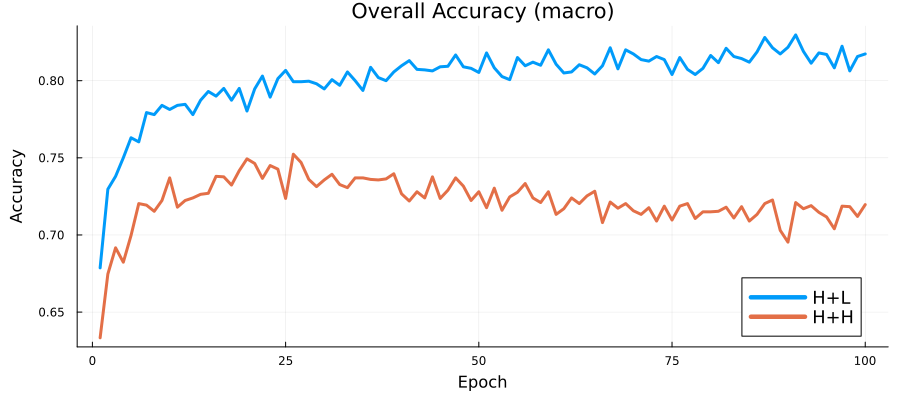

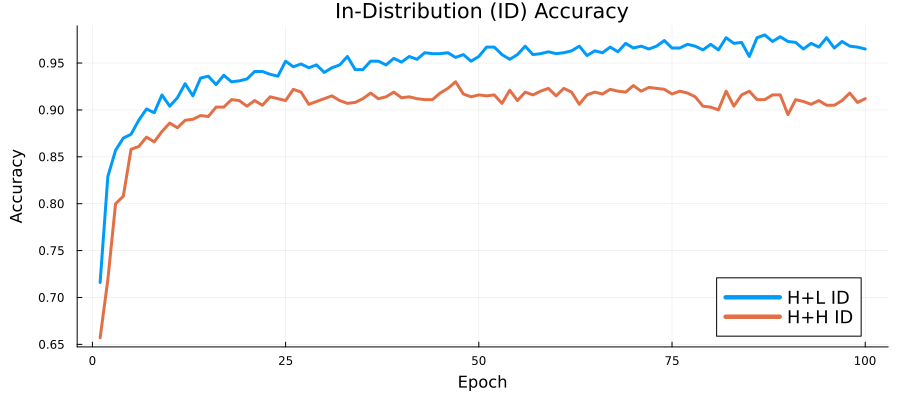

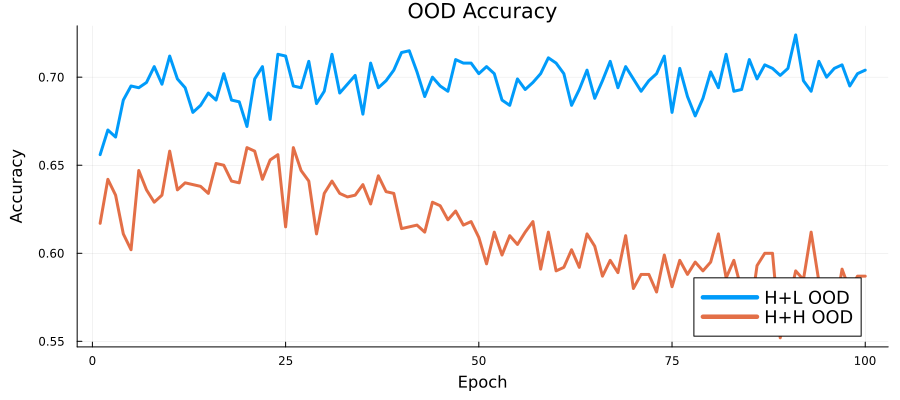

"ood_vs_epoch.png"

In [32]:


# --- Compute Overall (macro average) with a loop ---
overall_HL = Float64[]
overall_HH = Float64[]

for i in 1:nrow(df_HL)
    push!(overall_HL, (df_HL.ID[i] + df_HL.MID[i] + df_HL.OOD[i]) / 3)
end
for i in 1:nrow(df_HH)
    push!(overall_HH, (df_HH.ID[i] + df_HH.MID[i] + df_HH.OOD[i]) / 3)
end

df_HL.Overall = overall_HL
df_HH.Overall = overall_HH

# --- Simple plots ---
Plots.default(size=(900,400))

# Overall accuracy (macro)
p_overall = plot(xlabel="Epoch", ylabel="Accuracy", title="Overall Accuracy (macro)", legend=:bottomright,
                     left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p_overall, df_HL.epoch, df_HL.Overall, lw=3, label="H+L")
plot!(p_overall, df_HH.epoch, df_HH.Overall, lw=3, ls=:solid, label="H+H")
display(p_overall)
png(p_overall, "overall_vs_epoch.png")

p_id = plot(xlabel="Epoch", ylabel="Accuracy", title="In-Distribution (ID) Accuracy",
            legend=:bottomright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12)

plot!(p_id, df_HL.epoch, df_HL.ID, lw=3, label="H+L ID")
plot!(p_id, df_HH.epoch, df_HH.ID, lw=3, ls=:solid, label="H+H ID")

display(p_id)
png(p_id, "id_vs_epoch.png")

# OOD accuracy
p_ood = plot(xlabel="Epoch", ylabel="Accuracy", title="OOD Accuracy", legend=:bottomright,
                left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p_ood, df_HL.epoch, df_HL.OOD, lw=3, label="H+L OOD")
plot!(p_ood, df_HH.epoch, df_HH.OOD, lw=3, ls=:solid, label="H+H OOD")
display(p_ood)
png(p_ood, "ood_vs_epoch.png")

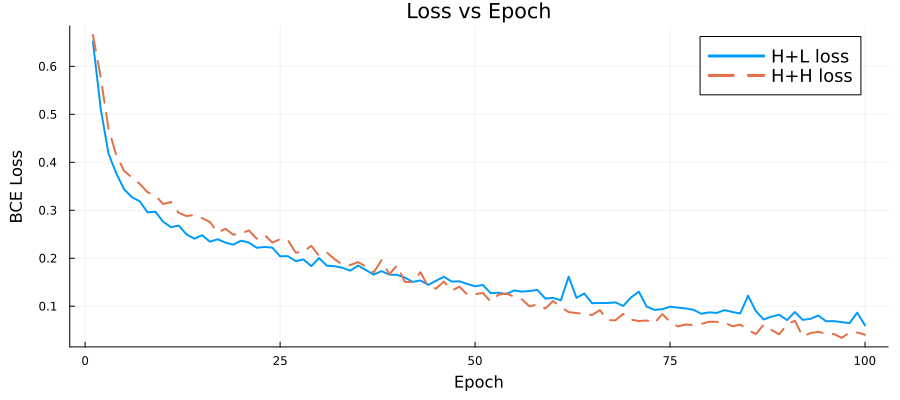

"/home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/LossVSepoc.png"

In [28]:
p4 = plot(title="Loss vs Epoch", xlabel="Epoch", ylabel="BCE Loss", legend=:topright,
left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p4, df_HL.epoch, df_HL.loss, lw=2, label="H+L loss")
plot!(p4, df_HH.epoch, df_HH.loss, lw=2, ls=:dash, label="H+H loss")
display(p4)
savefig(p4,"LossVSepoc.png")

In [31]:
using CSV, DataFrames, Dates

# --- Load logs ---
df_HL = CSV.read("hl_log.csv", DataFrame)
df_HH = CSV.read("hh_log.csv", DataFrame)

# --- Final summaries (plain indexing) ---
iL, iH = nrow(df_HL), nrow(df_HH)
summary_last = DataFrame(
    Model = ["H+L","H+H"],
    Epoch = [df_HL.epoch[iL], df_HH.epoch[iH]],
    pB    = [df_HL.pB[iL],    df_HH.pB[iH]],
    Loss  = [df_HL.loss[iL],  df_HH.loss[iH]],
    ID    = [df_HL.ID[iL],    df_HH.ID[iH]],
    MID   = [df_HL.MID[iL],   df_HH.MID[iH]],
    OOD   = [df_HL.OOD[iL],   df_HH.OOD[iH]],
    OOD7  = [df_HL.OOD7[iL],  df_HH.OOD7[iH]],
    OOD8  = [df_HL.OOD8[iL],  df_HH.OOD8[iH]],
)

iPeakHL, iPeakHH = argmax(df_HL.OOD), argmax(df_HH.OOD)
summary_peak = DataFrame(
    Model    = ["H+L","H+H"],
    PeakOOD  = [df_HL.OOD[iPeakHL], df_HH.OOD[iPeakHH]],
    AtEpoch  = [df_HL.epoch[iPeakHL], df_HH.epoch[iPeakHH]],
    pB       = [df_HL.pB[iPeakHL],    df_HH.pB[iPeakHH]],
    ID_at    = [df_HL.ID[iPeakHL],    df_HH.ID[iPeakHH]],
    MID_at   = [df_HL.MID[iPeakHL],   df_HH.MID[iPeakHH]],
)

diff_last = DataFrame(
    Metric = ["Loss","ID","MID","OOD","OOD7","OOD8"],
    Delta  = [summary_last.Loss[1]-summary_last.Loss[2],
              summary_last.ID[1]-summary_last.ID[2],
              summary_last.MID[1]-summary_last.MID[2],
              summary_last.OOD[1]-summary_last.OOD[2],
              summary_last.OOD7[1]-summary_last.OOD7[2],
              summary_last.OOD8[1]-summary_last.OOD8[2]],
)

# --- Simple LaTeX table function (using eachrow) ---
function df_to_latex_basic(df::DataFrame, caption::AbstractString="", label::AbstractString="")
    cols = names(df)
    aligns = [eltype(df[!, c]) <: Number ? "r" : "l" for c in cols]
    colspec = join(aligns, "")
    header  = join(string.(cols), " & ")

    io = IOBuffer()
    println(io, "\\begin{table}[t]")
    println(io, "\\centering")
    println(io, "\\begin{tabular}{", colspec, "}")
    println(io, "\\hline")
    println(io, header, " \\\\")
    println(io, "\\hline")
    for row in eachrow(df)
        vals = [string(row[c]) for c in cols]
        println(io, join(vals, " & "), " \\\\")
    end
    println(io, "\\hline")
    println(io, "\\end{tabular}")
    if !isempty(caption); println(io, "\\caption{", caption, "}"); end
    if !isempty(label);   println(io, "\\label{", label,   "}"); end
    println(io, "\\end{table}")
    return String(take!(io))
end

# --- Print LaTeX tables to REPL ---
println(df_to_latex_basic(summary_last, "Final-epoch summary", "tab:final"))
println(df_to_latex_basic(summary_peak, "Peak OOD summary", "tab:peak"))
println(df_to_latex_basic(diff_last,    "Final-epoch differences (H+L-H+H)", "tab:diff"))

# --- Save LaTeX tables to files ---
ts = Dates.format(now(), "yyyymmdd_HHMMSS")
open("summary_last_$ts.tex","w") do io; write(io, df_to_latex_basic(summary_last, "Final-epoch summary", "tab:final")); end
open("summary_peak_$ts.tex","w") do io; write(io, df_to_latex_basic(summary_peak, "Peak OOD summary", "tab:peak")); end
open("diff_last_$ts.tex","w")  do io; write(io, df_to_latex_basic(diff_last, "Final-epoch differences (H+L-H+H)", "tab:diff")); end


\begin{table}[t]
\centering
\begin{tabular}{lrrrrrrrr}
\hline
Model & Epoch & pB & Loss & ID & MID & OOD & OOD7 & OOD8 \\
\hline
H+L & 100 & 1.0 & 0.05999790815203577 & 0.965 & 0.783 & 0.704 & 0.712 & 0.696 \\
H+H & 100 & 1.0 & 0.040605767602266654 & 0.912 & 0.66 & 0.587 & 0.596 & 0.578 \\
\hline
\end{tabular}
\caption{Final-epoch summary}
\label{tab:final}
\end{table}

\begin{table}[t]
\centering
\begin{tabular}{lrrrrr}
\hline
Model & PeakOOD & AtEpoch & pB & ID_at & MID_at \\
\hline
H+L & 0.724 & 91 & 0.945514773925705 & 0.972 & 0.793 \\
H+H & 0.66 & 20 & 0.0 & 0.904 & 0.684 \\
\hline
\end{tabular}
\caption{Peak OOD summary}
\label{tab:peak}
\end{table}

\begin{table}[t]
\centering
\begin{tabular}{lr}
\hline
Metric & Delta \\
\hline
Loss & 0.019392140549769114 \\
ID & 0.052999999999999936 \\
MID & 0.123 \\
OOD & 0.11699999999999999 \\
OOD7 & 0.11599999999999999 \\
OOD8 & 0.118 \\
\hline
\end{tabular}
\caption{Final-epoch differences (H+L-H+H)}
\label{tab:diff}
\end{table}



324